# Audience Decode: Understanding Viewer Behavior on a Streaming Platform

This notebook explores a large dataset of movie ratings from a streaming platform. Our goals are:

1. **Exploratory Data Analysis** - understand the data, find patterns, identify interesting trends
2. **Rating Prediction** - build models to predict whether a user will give a high rating (4-5 stars) or low rating (1-3 stars)
3. **User Behavior Analysis** - cluster users into behavioral groups and analyze how their preferences evolve over time
4. **Behavior Shift Prediction** - predict which users are likely to change their rating patterns

The dataset contains over 4 million ratings from ~440k users across ~16k movies, spanning from 1995 to 2006.


## Part 1: Setup and Data Loading

First, let's import all the libraries we'll need and set up our environment. We're using pandas for data manipulation, sklearn for machine learning, and matplotlib/seaborn for visualizations.


In [4]:
import sqlite3
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ML imports
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    silhouette_score
)

# SHAP for feature importance explanations
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed, will skip SHAP visualizations")

warnings.filterwarnings('ignore')

# plotting setup
pd.set_option("display.max_columns", 50)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

# create images folder if it doesn't exist
Path("images").mkdir(exist_ok=True)

print("All imports loaded successfully!")


All imports loaded successfully!


### Loading the Data

We have pre-split databases to ensure proper train/validation/test separation:
- **Training set (70%)** - used to train our models
- **Validation set (15%)** - used to tune hyperparameters and compare models
- **Test set (15%)** - held out for final evaluation only

This split was done randomly at the rating level to prevent data leakage.


In [5]:
# paths to our databases
TRAIN_DB = Path("./viewer_interactions_train.db")
VAL_DB = Path("./viewer_interactions_val.db")
TEST_DB = Path("./viewer_interactions_test.db")
FULL_DB = Path("./viewer_interactions.db")

# quick check that files exist
for db in [TRAIN_DB, VAL_DB, TEST_DB, FULL_DB]:
    if not db.exists():
        print(f"WARNING: {db} not found!")
    else:
        print(f"Found: {db}")

def load_tables(db_path):
    """Load all tables from a database file."""
    conn = sqlite3.connect(db_path)
    ratings = pd.read_sql("SELECT * FROM viewer_ratings", conn)
    user_stats = pd.read_sql("SELECT * FROM user_statistics", conn)
    movie_stats = pd.read_sql("SELECT * FROM movie_statistics", conn)
    conn.close()
    return ratings, user_stats, movie_stats


Found: viewer_interactions_train.db
Found: viewer_interactions_val.db
Found: viewer_interactions_test.db
Found: viewer_interactions.db


In [6]:
# load training data
train_ratings, train_user_stats, train_movie_stats = load_tables(TRAIN_DB)
print("Training set:")
print(f"  Ratings: {train_ratings.shape[0]:,} rows")
print(f"  Users: {train_user_stats.shape[0]:,}")
print(f"  Movies: {train_movie_stats.shape[0]:,}")

# load validation data
val_ratings, val_user_stats, val_movie_stats = load_tables(VAL_DB)
print("\nValidation set:")
print(f"  Ratings: {val_ratings.shape[0]:,} rows")
print(f"  Users: {val_user_stats.shape[0]:,}")
print(f"  Movies: {val_movie_stats.shape[0]:,}")

# load test data
test_ratings, test_user_stats, test_movie_stats = load_tables(TEST_DB)
print("\nTest set:")
print(f"  Ratings: {test_ratings.shape[0]:,} rows")
print(f"  Users: {test_user_stats.shape[0]:,}")
print(f"  Movies: {test_movie_stats.shape[0]:,}")


Training set:
  Ratings: 2,817,500 rows
  Users: 405,158
  Movies: 12,980

Validation set:
  Ratings: 603,750 rows
  Users: 238,836
  Movies: 4,170

Test set:
  Ratings: 603,750 rows
  Users: 238,412
  Movies: 4,180


For the EDA section, we'll also load the full dataset to get a complete picture of the data before it was split.


In [7]:
# load full database for EDA
conn = sqlite3.connect(FULL_DB)

# check what tables we have
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Tables in database:", list(tables['name']))

# load everything
full_ratings = pd.read_sql("SELECT * FROM viewer_ratings", conn)
movies = pd.read_sql("SELECT * FROM movies", conn)
full_user_stats = pd.read_sql("SELECT * FROM user_statistics", conn)
full_movie_stats = pd.read_sql("SELECT * FROM movie_statistics", conn)

# there's also a data dictionary - let's check it
data_dict = pd.read_sql("SELECT * FROM data_dictionary", conn)
conn.close()

print(f"\nFull dataset has {full_ratings.shape[0]:,} ratings")


Tables in database: ['viewer_ratings', 'movies', 'user_statistics', 'movie_statistics', 'data_dictionary']

Full dataset has 4,025,000 ratings


Let's take a quick look at what each table contains:


In [8]:
print("=== viewer_ratings (first 5 rows) ===")
display(full_ratings.head())

print("\n=== movies (first 5 rows) ===")
display(movies.head())

print("\n=== user_statistics (first 5 rows) ===")
display(full_user_stats.head())

print("\n=== movie_statistics (first 5 rows) ===")
display(full_movie_stats.head())


=== viewer_ratings (first 5 rows) ===


,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.0,2005-10-09,NaN
1,9236,1448424,5.0,2005-11-15,NaN
2,4640,2308980,NaN,2005-08-06,NaN
3,9330,674346,3.0,2005-04-29,NaN
4,4570,1304045,4.0,2005-09-19,NaN



=== movies (first 5 rows) ===


,movie_id,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW



=== user_statistics (first 5 rows) ===


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,2004-08-11,2005-06-06,299.0
1,506434,1.0,4.000000,NaN,4.0,4.0,1.0,2005-08-02,2005-08-02,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,2004-11-16,2005-01-19,64.0
3,396632,2.0,NaN,0.000000,4.0,4.0,2.0,2004-07-07,2004-07-07,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,2004-03-02,2004-10-13,NaN



=== movie_statistics (first 5 rows) ===


,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users,first_rating_date,last_rating_date,year_of_release,title
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0,2003-07-12,2005-12-30,2003.0,Dinosaur Planet
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0,2004-10-16,2005-12-20,2004.0,Isle of Man TT 2004 Review
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0,2000-10-19,2005-12-30,1997.0,Character
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0,2003-12-06,2005-12-27,1994.0,Paula Abdul's Get Up & Dance
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0,2004-11-02,2005-12-29,2004.0,The Rise and Fall of ECW


---
## Part 2: Exploratory Data Analysis (EDA)

Now let's dive into the data and understand what we're working with. We'll examine:
1. Rating distribution - how are ratings spread across 1-5 stars?
2. User activity patterns - how active are users on the platform?
3. Temporal trends - how has rating behavior changed over time?
4. Movie popularity - which movies get the most attention?

### 2.1 Rating Distribution

First, let's look at how ratings are distributed. This tells us whether users tend to be generous or critical with their ratings.


In [9]:
# convert rating to numeric and clean up
full_ratings['rating'] = pd.to_numeric(full_ratings['rating'], errors='coerce')
full_ratings['date'] = pd.to_datetime(full_ratings['date'], errors='coerce')

# basic stats
total_ratings = len(full_ratings)
valid_ratings = full_ratings['rating'].notna().sum()
missing_ratings = full_ratings['rating'].isna().sum()

print(f"Total records: {total_ratings:,}")
print(f"Valid ratings: {valid_ratings:,} ({valid_ratings/total_ratings*100:.1f}%)")
print(f"Missing ratings: {missing_ratings:,} ({missing_ratings/total_ratings*100:.1f}%)")

print("\nRating value counts:")
print(full_ratings['rating'].value_counts().sort_index())


Total records: 4,025,000
Valid ratings: 3,622,500 (90.0%)
Missing ratings: 402,500 (10.0%)

Rating value counts:
rating
0.0        385
1.0     166369
2.0     354148
3.0    1026947
4.0    1256745
5.0     817530
6.0        376
Name: count, dtype: int64


The histogram below shows this distribution visually. We expect to see a pattern skewed toward higher ratings (4-5 stars), as most users only bother to rate movies they liked.


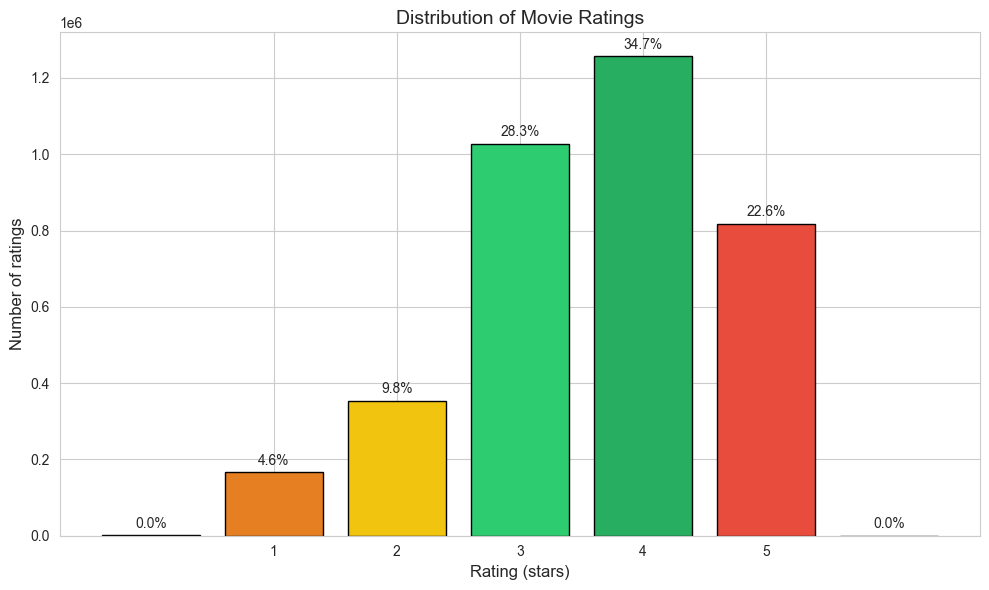


High ratings (4-5 stars): 57.3%
Low ratings (1-3 stars): 42.7%


In [10]:
# rating distribution plot
fig, ax = plt.subplots(figsize=(10, 6))

rating_counts = full_ratings['rating'].value_counts().sort_index()
colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
ax.bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black')

ax.set_xlabel('Rating (stars)', fontsize=12)
ax.set_ylabel('Number of ratings', fontsize=12)
ax.set_title('Distribution of Movie Ratings', fontsize=14)
ax.set_xticks([1, 2, 3, 4, 5])

# add percentage labels on bars
for i, (rating, count) in enumerate(rating_counts.items()):
    pct = count / valid_ratings * 100
    ax.text(rating, count + 20000, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('images/rating_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# for our ML task, let's define high rating as 4-5 stars
high_rating_pct = rating_counts.loc[[4, 5]].sum() / valid_ratings * 100
low_rating_pct = rating_counts.loc[[1, 2, 3]].sum() / valid_ratings * 100
print(f"\nHigh ratings (4-5 stars): {high_rating_pct:.1f}%")
print(f"Low ratings (1-3 stars): {low_rating_pct:.1f}%")


**Observation:** As expected, ratings are skewed toward higher values. Most users give 4-star ratings, followed by 3 and 5 stars. This is common in rating systems - people are more likely to rate things they enjoy.

For our classification task, we'll define:
- **High rating** = 4 or 5 stars (positive experience)
- **Low rating** = 1, 2, or 3 stars (neutral to negative experience)

This gives us a roughly 57%/43% split, which is reasonably balanced for classification.

### 2.2 User Activity Patterns

Let's understand how users engage with the platform. Are most users casual viewers with just a few ratings, or do we have many power users?


In [11]:
# clean up user statistics
for col in ['total_ratings', 'unique_movies', 'activity_days', 'avg_rating', 'std_rating']:
    if col in full_user_stats.columns:
        full_user_stats[col] = pd.to_numeric(full_user_stats[col], errors='coerce')

n_users = full_ratings['customer_id'].nunique()
n_movies = full_ratings['movie_id'].nunique()

print(f"Unique users: {n_users:,}")
print(f"Unique movies: {n_movies:,}")

# ratings per user
ratings_per_user = full_ratings.groupby('customer_id').size()
print(f"\nRatings per user:")
print(f"  Mean: {ratings_per_user.mean():.1f}")
print(f"  Median: {ratings_per_user.median():.1f}")
print(f"  Max: {ratings_per_user.max():,}")
print(f"  Min: {ratings_per_user.min()}")


Unique users: 438,570
Unique movies: 16,013

Ratings per user:
  Mean: 9.2
  Median: 4.0
  Max: 764
  Min: 1


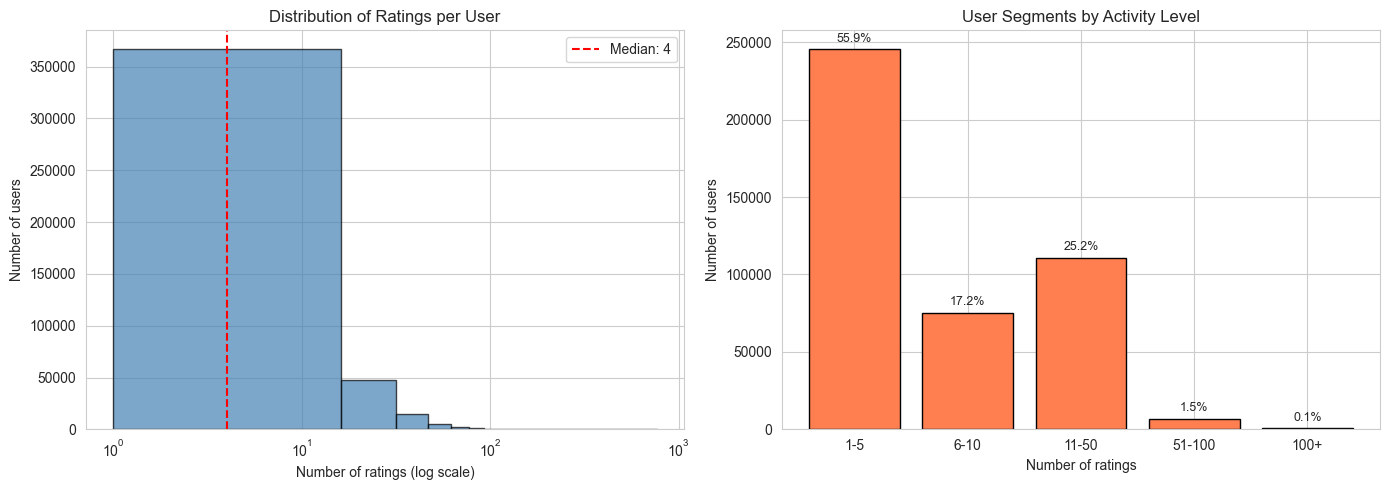

In [12]:
# visualize user activity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left: histogram of ratings per user (log scale because of heavy tail)
axes[0].hist(ratings_per_user, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')
axes[0].set_xlabel('Number of ratings (log scale)')
axes[0].set_ylabel('Number of users')
axes[0].set_title('Distribution of Ratings per User')
axes[0].axvline(ratings_per_user.median(), color='red', linestyle='--', label=f'Median: {ratings_per_user.median():.0f}')
axes[0].legend()

# right: user segments by activity level
bins = [0, 5, 10, 50, 100, float('inf')]
labels = ['1-5', '6-10', '11-50', '51-100', '100+']
user_segments = pd.cut(ratings_per_user, bins=bins, labels=labels)
segment_counts = user_segments.value_counts().sort_index()

axes[1].bar(segment_counts.index, segment_counts.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of ratings')
axes[1].set_ylabel('Number of users')
axes[1].set_title('User Segments by Activity Level')

# add percentages
for i, (seg, count) in enumerate(segment_counts.items()):
    pct = count / len(ratings_per_user) * 100
    axes[1].text(i, count + 5000, f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('images/user_activity.png', dpi=150, bbox_inches='tight')
plt.show()


**Observation:** The user activity distribution follows a heavy-tailed pattern (also called a power law). Most users are casual - they rate only a handful of movies. But there's a small group of "power users" who rate hundreds of movies.

This is important for our analysis because:
- Casual users might have less predictable preferences
- Power users provide more signal but are a small minority
- We should consider user activity level as a feature in our models

### 2.3 Temporal Trends

Let's see how rating activity has evolved over time. This can reveal platform growth patterns and potential seasonality.


In [13]:
# time range of the data
print(f"Date range: {full_ratings['date'].min()} to {full_ratings['date'].max()}")

# check for anomalous dates
if 'anomalous_date' in full_ratings.columns:
    anomalous = (full_ratings['anomalous_date'] == 1).sum()
    print(f"Anomalous dates flagged: {anomalous:,}")

# ratings by year
ratings_with_date = full_ratings.dropna(subset=['date']).copy()
ratings_with_date['year'] = ratings_with_date['date'].dt.year
ratings_with_date['month'] = ratings_with_date['date'].dt.month
ratings_with_date['year_month'] = ratings_with_date['date'].dt.to_period('M')

ratings_by_year = ratings_with_date.groupby('year').size()
print("\nRatings by year:")
print(ratings_by_year)


Date range: 1995-01-01 00:00:00 to 2006-03-28 00:00:00
Anomalous dates flagged: 1,209

Ratings by year:
year
1995        137
1996        134
1997        123
1998        457
1999       2170
2000      37655
2001      74216
2002     183729
2003     374847
2004    1287590
2005    2063531
2006        411
dtype: int64


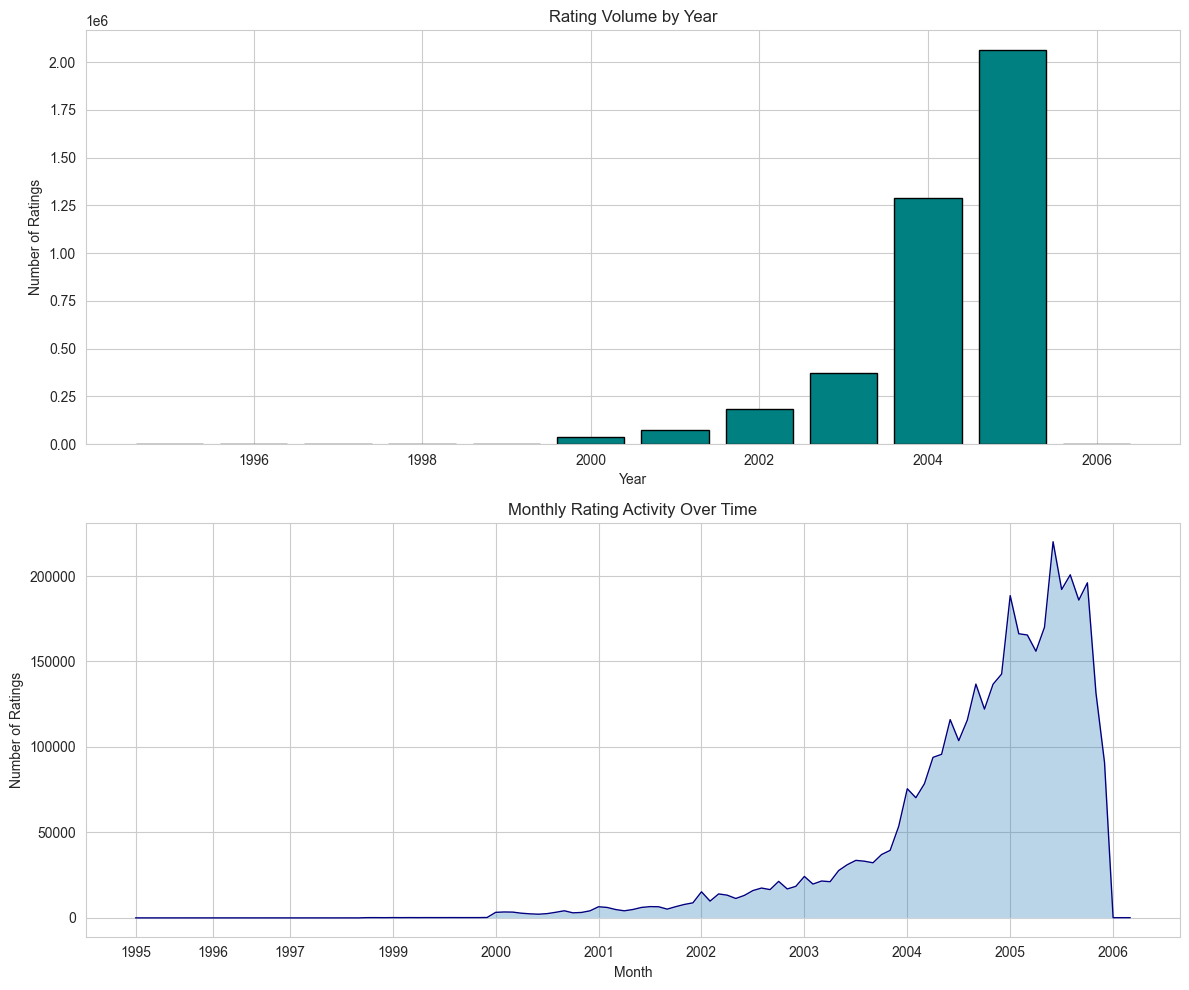

In [14]:
# visualize temporal trends
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ratings per year
axes[0].bar(ratings_by_year.index, ratings_by_year.values, color='teal', edgecolor='black')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_title('Rating Volume by Year')

# monthly trend (detailed)
monthly_ratings = ratings_with_date.groupby('year_month').size()
axes[1].plot(range(len(monthly_ratings)), monthly_ratings.values, color='navy', linewidth=1)
axes[1].fill_between(range(len(monthly_ratings)), monthly_ratings.values, alpha=0.3)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Ratings')
axes[1].set_title('Monthly Rating Activity Over Time')

# set x-axis labels to show years
tick_positions = [i for i, ym in enumerate(monthly_ratings.index) if str(ym).endswith('-01')]
tick_labels = [str(monthly_ratings.index[i])[:4] for i in tick_positions]
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)

plt.tight_layout()
plt.savefig('images/temporal_trends.png', dpi=150, bbox_inches='tight')
plt.show()


**Observation:** The platform saw massive growth from 1999 onwards, peaking around 2005. The monthly view shows clear seasonality with peaks that could correspond to holiday periods when people watch more movies. This temporal information could be useful as features in our model.

### 2.4 User Rating Behavior

Let's examine how harsh or generous users tend to be with their ratings. This will help us understand user "personalities" and prepare for our clustering analysis later.


In [15]:
# average rating per user (from user_statistics table)
print("User average rating distribution:")
print(full_user_stats['avg_rating'].describe())

# categorize users by their typical rating behavior
def categorize_user(avg):
    if pd.isna(avg):
        return 'Unknown'
    elif avg < 2.5:
        return 'Harsh (< 2.5)'
    elif avg < 3.5:
        return 'Moderate (2.5-3.5)'
    elif avg < 4.0:
        return 'Generous (3.5-4)'
    else:
        return 'Very Generous (4+)'

full_user_stats['rating_type'] = full_user_stats['avg_rating'].apply(categorize_user)
user_type_counts = full_user_stats['rating_type'].value_counts()
print("\nUser rating tendencies:")
print(user_type_counts)


User average rating distribution:
count    416841.000000
mean          3.632195
std           0.812457
min           0.000000
25%           3.185185
50%           3.687500
75%           4.000000
max           6.000000
Name: avg_rating, dtype: float64

User rating tendencies:
rating_type
Very Generous (4+)    163614
Moderate (2.5-3.5)    122952
Generous (3.5-4)      101297
Harsh (< 2.5)          28978
Unknown                21939
Name: count, dtype: int64


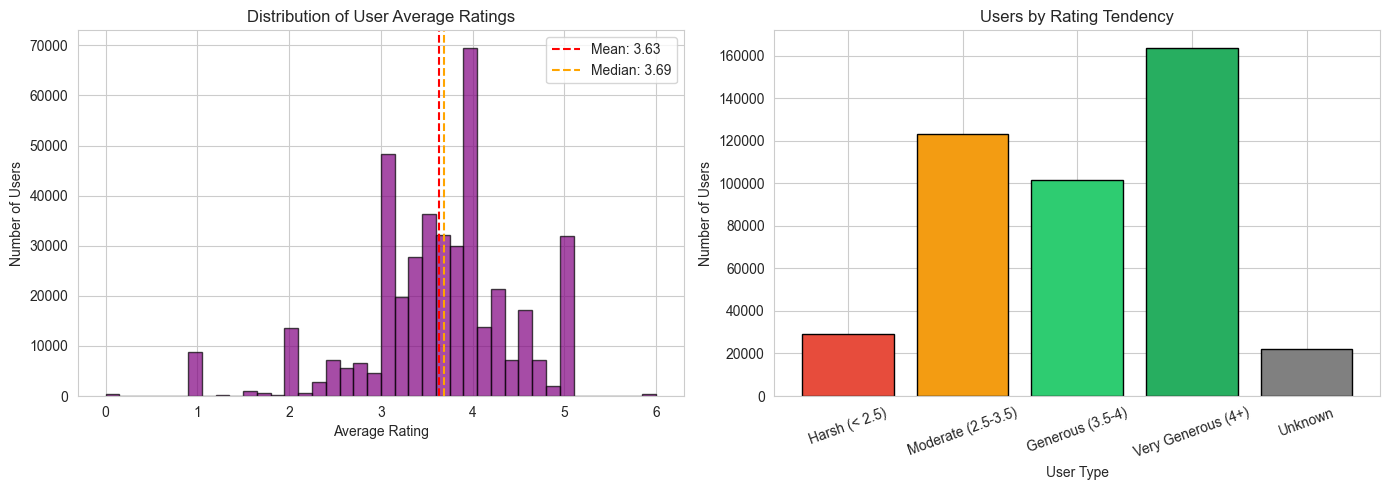

In [16]:
# visualize user rating types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram of average ratings
axes[0].hist(full_user_stats['avg_rating'].dropna(), bins=40, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(full_user_stats['avg_rating'].mean(), color='red', linestyle='--', 
                label=f"Mean: {full_user_stats['avg_rating'].mean():.2f}")
axes[0].axvline(full_user_stats['avg_rating'].median(), color='orange', linestyle='--', 
                label=f"Median: {full_user_stats['avg_rating'].median():.2f}")
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of User Average Ratings')
axes[0].legend()

# bar chart of user types
order = ['Harsh (< 2.5)', 'Moderate (2.5-3.5)', 'Generous (3.5-4)', 'Very Generous (4+)', 'Unknown']
colors_map = {'Harsh (< 2.5)': '#e74c3c', 'Moderate (2.5-3.5)': '#f39c12', 
              'Generous (3.5-4)': '#2ecc71', 'Very Generous (4+)': '#27ae60', 'Unknown': 'gray'}
counts = [user_type_counts.get(x, 0) for x in order]
colors_list = [colors_map[x] for x in order]
axes[1].bar(order, counts, color=colors_list, edgecolor='black')
axes[1].set_xlabel('User Type')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Users by Rating Tendency')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('images/user_rating_behavior.png', dpi=150, bbox_inches='tight')
plt.show()


**Observation:** Most users are "generous" raters (average rating between 3.5-4.0). Very few users are consistently harsh critics. This user-level characteristic is a strong feature for predicting individual ratings - a generous user is more likely to give high ratings.

### 2.5 Movie Popularity vs Quality

Is there a relationship between how popular a movie is (number of ratings) and how well-rated it is? Let's find out.


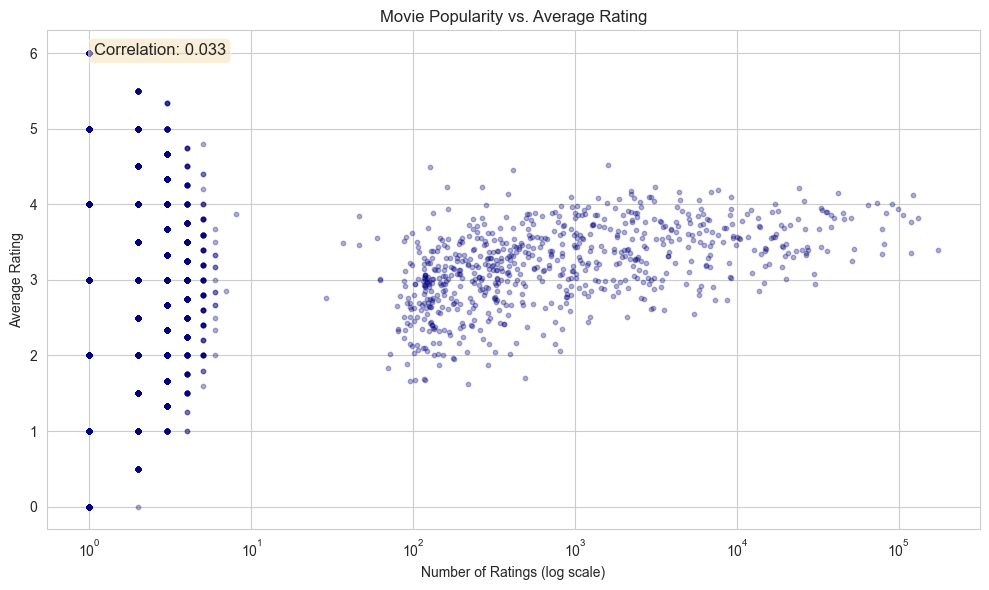

Correlation between popularity and rating: 0.033


In [17]:
# clean up movie statistics
for col in ['total_ratings', 'unique_users', 'avg_rating', 'year_of_release']:
    if col in full_movie_stats.columns:
        full_movie_stats[col] = pd.to_numeric(full_movie_stats[col], errors='coerce')

# scatter plot: popularity vs rating
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(full_movie_stats['total_ratings'], full_movie_stats['avg_rating'], 
           alpha=0.3, s=10, c='navy')
ax.set_xscale('log')
ax.set_xlabel('Number of Ratings (log scale)')
ax.set_ylabel('Average Rating')
ax.set_title('Movie Popularity vs. Average Rating')

# add correlation value
corr = full_movie_stats[['total_ratings', 'avg_rating']].corr().iloc[0, 1]
ax.annotate(f'Correlation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
            fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('images/popularity_vs_rating.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Correlation between popularity and rating: {corr:.3f}")


**Observation:** There's a weak positive correlation between popularity and rating. Movies with more ratings tend to be slightly better rated, but the relationship isn't strong. This makes sense - popular movies are popular for a reason (they're generally good), but there are also plenty of lesser-known gems and overhyped disappointments.

---
## Part 3: Data Preprocessing for ML

Now let's prepare our data for machine learning. We need to:
1. Clean the rating data (remove invalid values, anomalous dates)
2. Create our target variable (high rating vs low rating)
3. Merge user and movie statistics as features
4. Engineer additional features from the data


In [18]:
def preprocess_ratings(df):
    """Clean ratings data and create target variable."""
    df = df.copy()
    
    # ensure proper types
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # keep only valid ratings (1-5)
    df = df[df['rating'].between(1, 5)]
    
    # remove rows with anomalous dates if that column exists
    if 'anomalous_date' in df.columns:
        df = df[df['anomalous_date'] != 1]
    
    # drop rows where date is missing
    df = df.dropna(subset=['date'])
    
    # create target: 1 for high rating (4-5), 0 for low rating (1-3)
    df['high_rating'] = (df['rating'] >= 4).astype(int)
    
    return df

# preprocess all splits
train_clean = preprocess_ratings(train_ratings)
val_clean = preprocess_ratings(val_ratings)
test_clean = preprocess_ratings(test_ratings)

print(f"Training: {len(train_clean):,} ratings after cleaning")
print(f"Validation: {len(val_clean):,} ratings after cleaning")
print(f"Test: {len(test_clean):,} ratings after cleaning")

# check label balance
print(f"\nTraining label distribution:")
print(train_clean['high_rating'].value_counts(normalize=True))


Training: 2,534,658 ratings after cleaning
Validation: 542,940 ratings after cleaning
Test: 543,038 ratings after cleaning

Training label distribution:
high_rating
1    0.572452
0    0.427548
Name: proportion, dtype: float64


### 3.1 Feature Engineering

Let's merge user and movie statistics with our rating data and create additional features that might help predict ratings.


In [19]:
def prepare_user_stats(user_stats):
    """Prepare user statistics with renamed columns to avoid conflicts."""
    df = user_stats.copy()
    
    # convert to numeric
    for col in ['total_ratings', 'unique_movies', 'avg_rating', 'std_rating', 'activity_days']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # rename columns to indicate they're user-level
    rename_dict = {
        'total_ratings': 'user_total_ratings',
        'unique_movies': 'user_unique_movies',
        'avg_rating': 'user_avg_rating',
        'std_rating': 'user_std_rating',
        'activity_days': 'user_activity_days'
    }
    df = df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns})
    
    return df

def prepare_movie_stats(movie_stats):
    """Prepare movie statistics with renamed columns."""
    df = movie_stats.copy()
    
    for col in ['total_ratings', 'unique_users', 'avg_rating', 'year_of_release']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    rename_dict = {
        'total_ratings': 'movie_total_ratings',
        'unique_users': 'movie_unique_users',
        'avg_rating': 'movie_avg_rating',
        'year_of_release': 'movie_year'
    }
    df = df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns})
    
    return df

# prepare stats for each split
train_user_prepared = prepare_user_stats(train_user_stats)
train_movie_prepared = prepare_movie_stats(train_movie_stats)

val_user_prepared = prepare_user_stats(val_user_stats)
val_movie_prepared = prepare_movie_stats(val_movie_stats)

test_user_prepared = prepare_user_stats(test_user_stats)
test_movie_prepared = prepare_movie_stats(test_movie_stats)

print("User stats columns:", list(train_user_prepared.columns[:8]))


User stats columns: ['customer_id', 'user_total_ratings', 'user_avg_rating', 'user_std_rating', 'min_rating', 'max_rating', 'user_unique_movies', 'first_rating_date']


In [20]:
def build_features(ratings_df, user_stats, movie_stats):
    """Merge ratings with user/movie stats and create derived features."""
    
    # start with basic columns from ratings
    df = ratings_df[['customer_id', 'movie_id', 'rating', 'date', 'high_rating']].copy()
    
    # merge with user statistics
    df = df.merge(user_stats, on='customer_id', how='inner')
    
    # merge with movie statistics
    df = df.merge(movie_stats, on='movie_id', how='inner')
    
    # extract temporal features from rating date
    df['rating_year'] = df['date'].dt.year
    df['rating_month'] = df['date'].dt.month
    df['rating_dayofweek'] = df['date'].dt.dayofweek
    
    # movie age at time of rating
    df['movie_age'] = df['rating_year'] - df['movie_year']
    
    # user activity intensity
    activity_safe = df['user_activity_days'].replace(0, np.nan)
    df['user_ratings_per_month'] = df['user_total_ratings'] / (activity_safe / 30)
    
    return df

# build feature matrices for each split
train_features = build_features(train_clean, train_user_prepared, train_movie_prepared)
val_features = build_features(val_clean, val_user_prepared, val_movie_prepared)
test_features = build_features(test_clean, test_user_prepared, test_movie_prepared)

print(f"Training samples: {len(train_features):,}")
print(f"Validation samples: {len(val_features):,}")
print(f"Test samples: {len(test_features):,}")
print(f"\nFeatures available: {train_features.shape[1]} columns")


Training samples: 2,534,660
Validation samples: 542,941
Test samples: 543,038

Features available: 29 columns


In [21]:
# define which columns to use as features
numeric_features = [
    'user_total_ratings',
    'user_unique_movies', 
    'user_avg_rating',
    'user_std_rating',
    'user_activity_days',
    'user_ratings_per_month',
    'movie_total_ratings',
    'movie_unique_users',
    'movie_avg_rating',
    'movie_year',
    'movie_age',
    'rating_year'
]

categorical_features = [
    'rating_month',
    'rating_dayofweek'
]

def prepare_xy(features_df):
    """Extract X (features) and y (target) from feature dataframe."""
    df = features_df[numeric_features + categorical_features + ['high_rating']].copy()
    df = df.dropna(subset=['high_rating'])
    
    X = df[numeric_features + categorical_features]
    y = df['high_rating'].astype(int)
    
    return X, y

X_train, y_train = prepare_xy(train_features)
X_val, y_val = prepare_xy(val_features)
X_test, y_test = prepare_xy(test_features)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

# show sample of features
print("\nSample features:")
X_train.head()


X_train: (2534660, 14)
X_val: (542941, 14)
X_test: (543038, 14)

Sample features:


,user_total_ratings,user_unique_movies,user_avg_rating,user_std_rating,user_activity_days,user_ratings_per_month,movie_total_ratings,movie_unique_users,movie_avg_rating,movie_year,movie_age,rating_year,rating_month,rating_dayofweek
0,7,7,4.000000,0.816497,127,1.653543,16643,18503,3.667608,1995.0,10.0,2005,8,1
1,18,21,3.055556,0.725358,1113,0.485175,7997,8893,3.389271,1990.0,15.0,2005,5,0
2,43,47,3.395349,0.849076,619,2.084006,22815,25378,3.379575,2005.0,0.0,2005,6,2
3,4,4,2.750000,0.957427,15,8.000000,33328,37079,3.414126,2004.0,1.0,2005,2,4
4,13,14,4.076923,0.759555,73,5.342466,10157,11302,3.539431,2000.0,5.0,2005,6,3


---
## Part 4: Classification Task - Predicting High Ratings

Now we'll build models to predict whether a user will give a high rating (4-5 stars) to a movie. We'll:
1. Set up preprocessing pipelines
2. Train 3 different models: Logistic Regression, Random Forest, Gradient Boosting
3. Use cross-validation with grid search to find optimal hyperparameters
4. Compare model performance on the validation set
5. Evaluate the best model on the test set

### 4.1 Preprocessing Pipeline

We need to handle numeric and categorical features differently:
- **Numeric features**: Fill missing values with median, then standardize to mean=0, std=1
- **Categorical features**: Fill missing values with most frequent value, then one-hot encode


In [22]:
# preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# preprocessing pipeline for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine both into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Preprocessing pipeline ready")


Preprocessing pipeline ready


### 4.2 Model Training with Cross-Validation Hyperparameter Tuning

We'll use GridSearchCV to find the best hyperparameters for each model. The process:
1. Define a grid of hyperparameter values to try
2. For each combination, perform 5-fold cross-validation on training data
3. Select the combination with highest F1 score
4. Refit the best model on full training data

**Note:** Due to the large dataset size, we'll use a subset for hyperparameter tuning to keep runtime reasonable.


In [23]:
# for hyperparameter tuning, use a sample to speed things up
# (full dataset would take too long for grid search)
SAMPLE_SIZE = 100000
np.random.seed(42)

if len(X_train) > SAMPLE_SIZE:
    sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)
    X_train_sample = X_train.iloc[sample_idx]
    y_train_sample = y_train.iloc[sample_idx]
    print(f"Using sample of {SAMPLE_SIZE:,} for hyperparameter tuning")
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print(f"Using full training set ({len(X_train):,} samples)")

print(f"Sample label distribution: {y_train_sample.mean():.3f} high ratings")


Using sample of 100,000 for hyperparameter tuning
Sample label distribution: 0.572 high ratings


#### Logistic Regression

A linear model that estimates probability of high rating as a function of features. Key hyperparameters:
- **C**: Regularization strength (lower = more regularization)
- **penalty**: Type of regularization (L1 or L2)
- **solver**: Optimization algorithm


In [24]:
%%time

# logistic regression with grid search
lr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__penalty': ['l2'],  # l1 requires specific solvers
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': ['balanced', None]
}

print("Tuning Logistic Regression...")
lr_search = GridSearchCV(
    lr_pipe, 
    lr_param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
lr_search.fit(X_train_sample, y_train_sample)

print(f"\nBest parameters: {lr_search.best_params_}")
print(f"Best CV F1 score: {lr_search.best_score_:.4f}")


Tuning Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'classifier__C': 0.01, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best CV F1 score: 0.7785
CPU times: user 1.86 s, sys: 460 ms, total: 2.31 s
Wall time: 40.8 s


#### Random Forest

An ensemble of decision trees that vote on the prediction. Key hyperparameters:
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of each tree
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples in a leaf node
- **max_features**: Number of features to consider for best split


In [25]:
%%time

# random forest with grid search
rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

print("Tuning Random Forest...")
rf_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train_sample, y_train_sample)

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best CV F1 score: {rf_search.best_score_:.4f}")


Tuning Random Forest...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Best CV F1 score: 0.7838
CPU times: user 11.6 s, sys: 3.65 s, total: 15.3 s
Wall time: 16min 36s


#### Gradient Boosting

Trees trained sequentially, each one correcting errors of previous trees. Key hyperparameters:
- **n_estimators**: Number of boosting stages
- **learning_rate**: Shrinks contribution of each tree
- **max_depth**: Maximum depth of individual trees
- **min_samples_split**: Minimum samples to split a node
- **subsample**: Fraction of samples used for each tree


In [26]:
%%time

# gradient boosting with grid search
gb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5],
    'classifier__subsample': [0.8, 1.0]
}

print("Tuning Gradient Boosting...")
gb_search = GridSearchCV(
    gb_pipe,
    gb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
gb_search.fit(X_train_sample, y_train_sample)

print(f"\nBest parameters: {gb_search.best_params_}")
print(f"Best CV F1 score: {gb_search.best_score_:.4f}")


Tuning Gradient Boosting...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Best CV F1 score: 0.7905
CPU times: user 18.8 s, sys: 3.95 s, total: 22.8 s
Wall time: 31min 8s


### 4.3 Model Comparison on Validation Set

Now let's train each model with its best hyperparameters on the full training data and evaluate on the validation set.


In [27]:
def evaluate_model(model, X, y, name="Model"):
    """Evaluate a model and return metrics dictionary."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_proba)
    }
    return metrics, y_pred, y_proba

# get best models from grid search
best_models = {
    'Logistic Regression': lr_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'Gradient Boosting': gb_search.best_estimator_
}

# retrain on full training data and evaluate on validation
print("Retraining on full training data...")
val_results = []

for name, model in best_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    metrics, y_pred, y_proba = evaluate_model(model, X_val, y_val, name)
    val_results.append(metrics)
    
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")

# create comparison table
results_df = pd.DataFrame(val_results)
print("\n" + "="*60)
print("Validation Results Summary:")
print("="*60)
display(results_df.round(4))


Retraining on full training data...

Training Logistic Regression...
  Accuracy: 0.8066
  Precision: 0.8184
  Recall: 0.8518
  F1: 0.8347
  ROC-AUC: 0.8847

Training Random Forest...
  Accuracy: 0.8118
  Precision: 0.8202
  Recall: 0.8603
  F1: 0.8398
  ROC-AUC: 0.9038

Training Gradient Boosting...
  Accuracy: 0.8086
  Precision: 0.7822
  Recall: 0.9235
  F1: 0.8470
  ROC-AUC: 0.9156

Validation Results Summary:


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.8066,0.8184,0.8518,0.8347,0.8847
1,Random Forest,0.8118,0.8202,0.8603,0.8398,0.9038
2,Gradient Boosting,0.8086,0.7822,0.9235,0.8470,0.9156


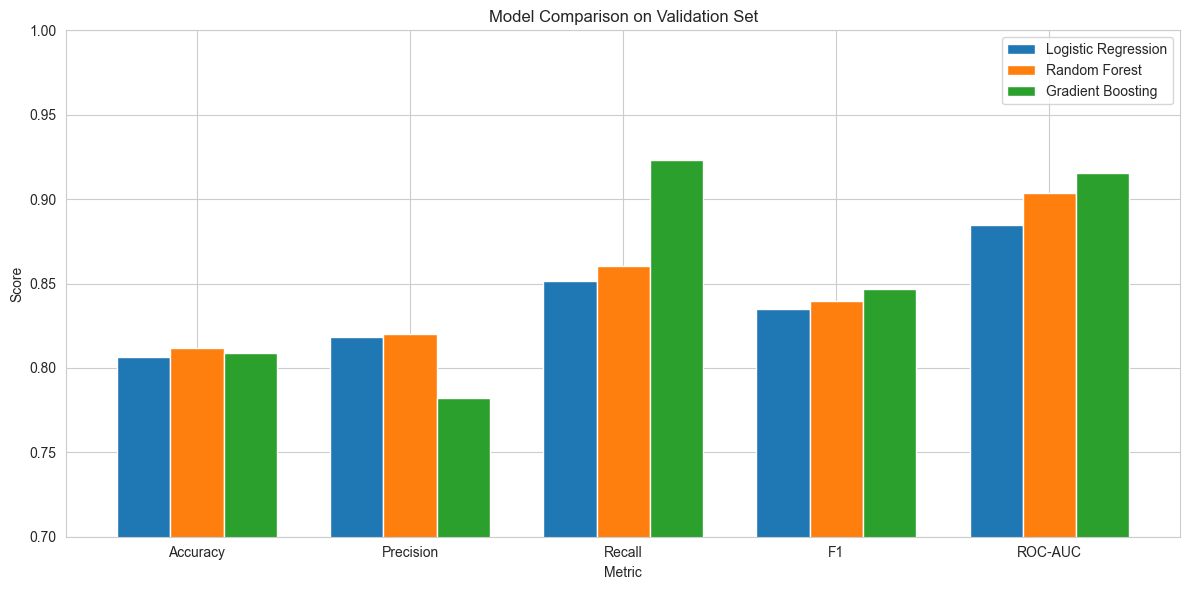

In [28]:
# visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (_, row) in enumerate(results_df.iterrows()):
    values = [row[m] for m in metrics_to_plot]
    ax.bar(x + i*width, values, width, label=row['model'])

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Model Comparison on Validation Set')
ax.set_xticks(x + width)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])
ax.legend()
ax.set_ylim(0.7, 1.0)

plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


### 4.4 Final Evaluation on Test Set

Now we select the best model based on validation F1 score, retrain on combined train+validation data, and evaluate on the held-out test set.


In [29]:
# find best model by F1 score
best_idx = results_df['f1'].idxmax()
best_model_name = results_df.loc[best_idx, 'model']
print(f"Best model by F1 score: {best_model_name}")

# get the corresponding model
best_model = best_models[best_model_name]

# combine train and validation for final training
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

print(f"\nRetraining on combined train+val: {len(X_train_full):,} samples")
best_model.fit(X_train_full, y_train_full)

# evaluate on test set
test_metrics, y_test_pred, y_test_proba = evaluate_model(best_model, X_test, y_test, best_model_name)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")


Best model by F1 score: Gradient Boosting

Retraining on combined train+val: 3,077,601 samples

FINAL TEST RESULTS
Accuracy:  0.8095
Precision: 0.7855
Recall:    0.9187
F1 Score:  0.8469
ROC-AUC:   0.9152



Classification Report:
              precision    recall  f1-score   support

  Low Rating       0.86      0.66      0.75    231532
 High Rating       0.79      0.92      0.85    311506

    accuracy                           0.81    543038
   macro avg       0.82      0.79      0.80    543038
weighted avg       0.82      0.81      0.80    543038



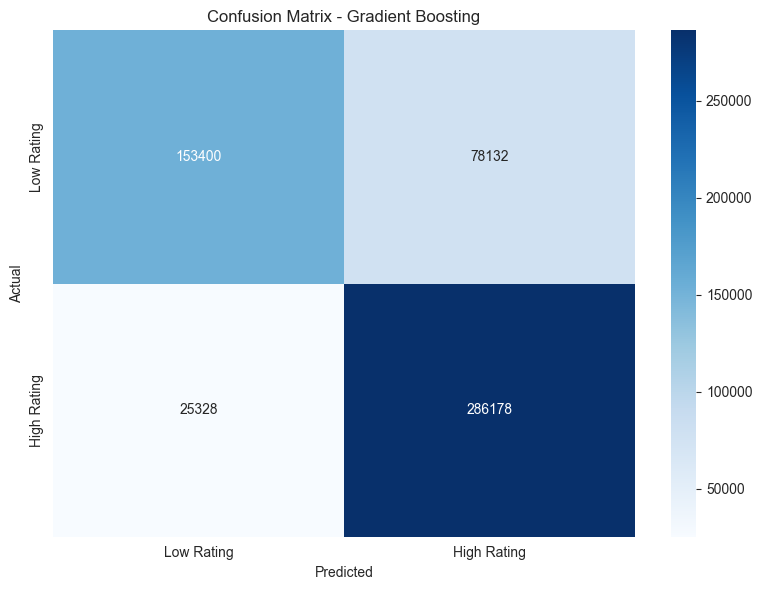

In [30]:
# confusion matrix and classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Low Rating', 'High Rating']))

# plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Low Rating', 'High Rating'],
            yticklabels=['Low Rating', 'High Rating'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


---
## Part 5: User Behavior Analysis

Now let's explore user behavior more deeply. We'll:
1. **Cluster users** into behavioral groups using K-Means
2. **Analyze behavior evolution** - how do users' rating patterns change over time?
3. **Predict behavior shift** - can we predict which users will change their behavior?
4. **Track cluster migration** - how do users move between clusters over time?

### 5.1 User Clustering with K-Means

Let's group users based on their rating behavior. We'll use features like average rating, rating variance, activity level, etc.


In [31]:
# prepare user-level features for clustering
clustering_features = ['user_avg_rating', 'user_std_rating', 'user_total_ratings', 
                       'user_activity_days', 'user_ratings_per_month']

# use training user stats (we'll cluster based on overall behavior)
user_cluster_data = train_user_prepared.copy()

# convert to numeric and drop missing
for col in clustering_features:
    if col in user_cluster_data.columns:
        user_cluster_data[col] = pd.to_numeric(user_cluster_data[col], errors='coerce')

# calculate ratings per month
activity_safe = user_cluster_data['user_activity_days'].replace(0, np.nan)
user_cluster_data['user_ratings_per_month'] = user_cluster_data['user_total_ratings'] / (activity_safe / 30)

# drop rows with missing values in clustering features
user_cluster_data = user_cluster_data.dropna(subset=clustering_features)
print(f"Users available for clustering: {len(user_cluster_data):,}")

# extract features for clustering
X_cluster = user_cluster_data[clustering_features].copy()

# standardize features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Feature statistics before scaling:")
print(X_cluster.describe().round(2))


Users available for clustering: 258,782
Feature statistics before scaling:
       user_avg_rating  user_std_rating  user_total_ratings  \
count        258782.00        258782.00           258782.00   
mean              3.66             0.89                9.00   
std               0.62             0.45                9.48   
min               1.00             0.00                2.00   
25%               3.29             0.60                3.00   
50%               3.67             0.84                6.00   
75%               4.00             1.14               11.00   
max               5.50             3.54              484.00   

       user_activity_days  user_ratings_per_month  
count           258782.00               258782.00  
mean               396.91                    3.86  
std                405.61                   18.22  
min                  1.00                    0.02  
25%                 90.00                    0.37  
50%                266.00                    

#### Finding Optimal Number of Clusters (Elbow Method)

We'll use the elbow method to determine the optimal number of clusters. We look for the "elbow" point where adding more clusters doesn't significantly reduce the within-cluster variance (inertia).


Finding optimal K...
  K=2: inertia=212081, silhouette=0.220
  K=3: inertia=176128, silhouette=0.225
  K=4: inertia=141785, silhouette=0.254
  K=5: inertia=126003, silhouette=0.267
  K=6: inertia=112157, silhouette=0.243
  K=7: inertia=101778, silhouette=0.238
  K=8: inertia=91335, silhouette=0.237
  K=9: inertia=85287, silhouette=0.236
  K=10: inertia=80233, silhouette=0.229


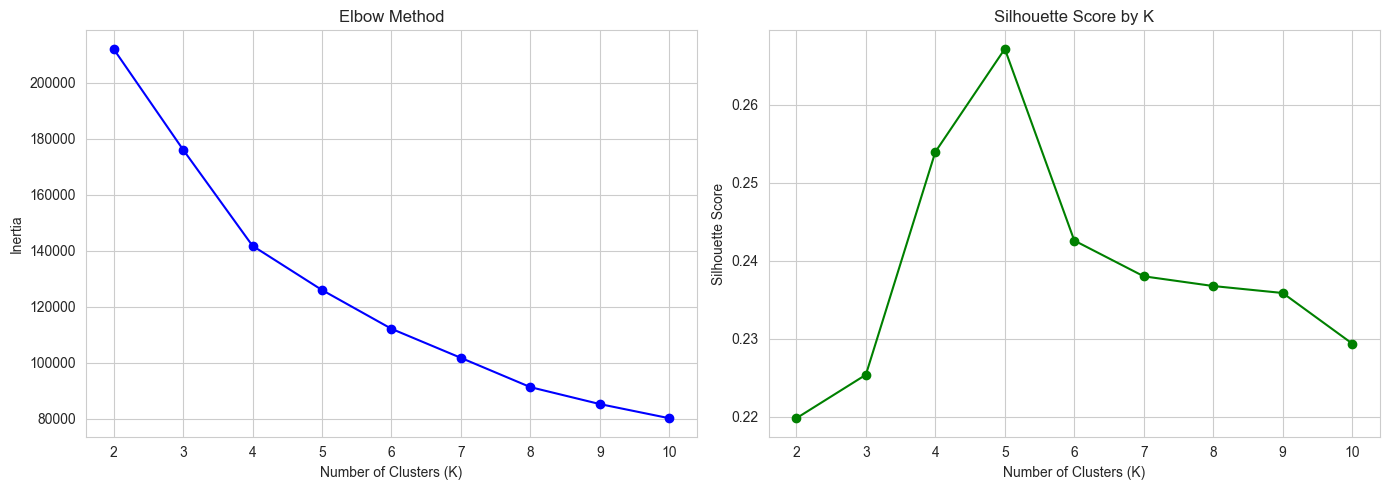


Best K by silhouette score: 5


In [32]:
# use a sample for faster computation
CLUSTER_SAMPLE = 50000
if len(X_cluster_scaled) > CLUSTER_SAMPLE:
    sample_idx = np.random.choice(len(X_cluster_scaled), CLUSTER_SAMPLE, replace=False)
    X_cluster_sample = X_cluster_scaled[sample_idx]
else:
    X_cluster_sample = X_cluster_scaled

# elbow method
k_range = range(2, 11)
inertias = []
silhouettes = []

print("Finding optimal K...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_sample)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_cluster_sample, kmeans.labels_))
    print(f"  K={k}: inertia={kmeans.inertia_:.0f}, silhouette={silhouettes[-1]:.3f}")

# plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(k_range, silhouettes, 'go-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by K')

plt.tight_layout()
plt.savefig('images/elbow_method.png', dpi=150, bbox_inches='tight')
plt.show()

# choose K based on silhouette score
best_k = k_range[np.argmax(silhouettes)]
print(f"\nBest K by silhouette score: {best_k}")


In [33]:
# fit final K-Means model
# we'll use 4 clusters for interpretability (can adjust based on elbow)
N_CLUSTERS = 4
kmeans_final = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
user_cluster_data['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# analyze cluster profiles
print("Cluster profiles (mean values):\n")
cluster_profiles = user_cluster_data.groupby('cluster')[clustering_features].mean()
display(cluster_profiles.round(2))

# cluster sizes
print("\nCluster sizes:")
print(user_cluster_data['cluster'].value_counts().sort_index())


Cluster profiles (mean values):



,user_avg_rating,user_std_rating,user_total_ratings,user_activity_days,user_ratings_per_month
cluster,,,,,
0,4.04,0.60,5.99,235.44,3.29
1,3.54,0.93,19.49,960.47,1.11
2,3.20,1.26,6.43,266.12,3.12
3,3.71,0.93,9.95,1.67,195.55



Cluster sizes:
cluster
0    119494
1     54579
2     83256
3      1453
Name: count, dtype: int64


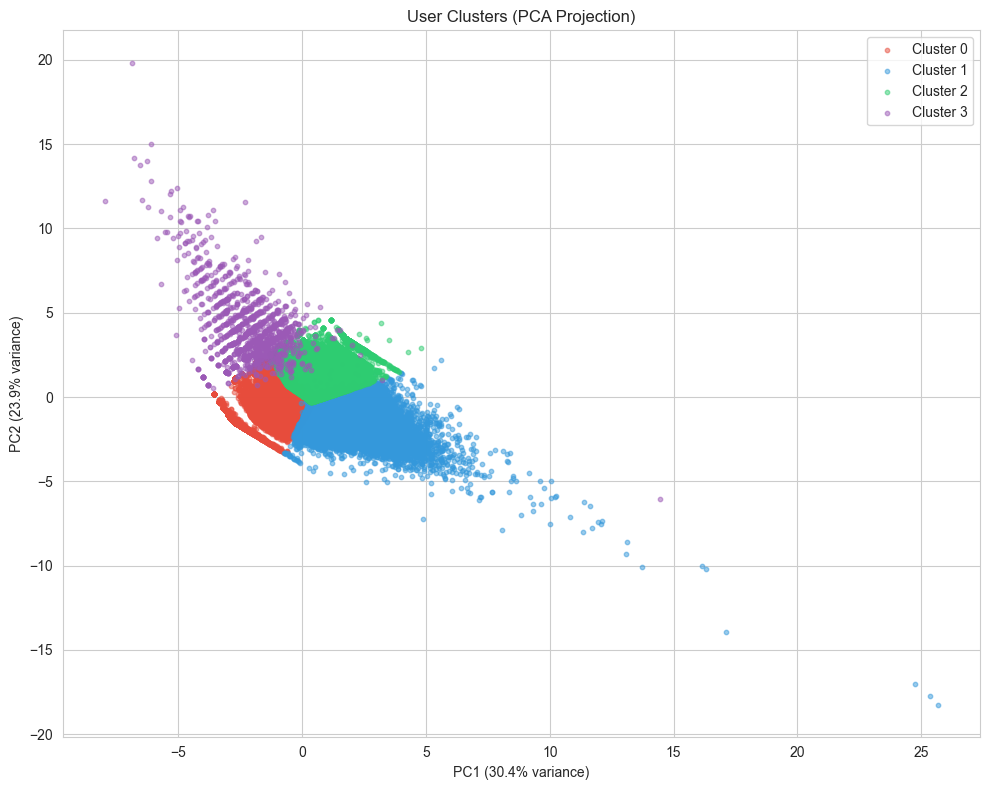

PCA explains 54.3% of variance


In [34]:
# visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# add to dataframe
user_cluster_data['pca1'] = X_pca[:, 0]
user_cluster_data['pca2'] = X_pca[:, 1]

# plot
fig, ax = plt.subplots(figsize=(10, 8))
cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

for i in range(N_CLUSTERS):
    mask = user_cluster_data['cluster'] == i
    ax.scatter(user_cluster_data.loc[mask, 'pca1'], 
               user_cluster_data.loc[mask, 'pca2'],
               c=cluster_colors[i], label=cluster_names[i], alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('User Clusters (PCA Projection)')
ax.legend()
plt.tight_layout()
plt.savefig('images/user_clusters_pca.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum()*100:.1f}% of variance")


### 5.2 Behavior Evolution Analysis

Now let's analyze how user behavior changes over time. For each user with enough ratings, we'll compare their "early period" behavior to their "late period" behavior and compute a "rating drift".


In [35]:
# for behavior evolution, we need the raw ratings with timestamps
# use training ratings
behavior_data = train_clean[['customer_id', 'rating', 'date']].copy()

# only keep users with at least 10 ratings (need enough data to split)
MIN_RATINGS = 10
user_counts = behavior_data.groupby('customer_id').size()
active_users = user_counts[user_counts >= MIN_RATINGS].index
behavior_data = behavior_data[behavior_data['customer_id'].isin(active_users)]

print(f"Users with at least {MIN_RATINGS} ratings: {len(active_users):,}")
print(f"Ratings from these users: {len(behavior_data):,}")


Users with at least 10 ratings: 81,512
Ratings from these users: 1,534,490


In [36]:
def compute_early_late_stats(group):
    """Split a user's ratings into early/late periods and compute stats."""
    group = group.sort_values('date')
    n = len(group)
    mid = n // 2
    
    early = group.iloc[:mid]
    late = group.iloc[mid:]
    
    return pd.Series({
        'early_count': len(early),
        'late_count': len(late),
        'early_avg_rating': early['rating'].mean(),
        'late_avg_rating': late['rating'].mean(),
        'early_std_rating': early['rating'].std() if len(early) > 1 else 0,
        'late_std_rating': late['rating'].std() if len(late) > 1 else 0,
        'early_days': (early['date'].max() - early['date'].min()).days,
        'late_days': (late['date'].max() - late['date'].min()).days,
    })

print("Computing early/late period statistics for each user...")
user_evolution = behavior_data.groupby('customer_id').apply(compute_early_late_stats)
user_evolution = user_evolution.reset_index()

# compute rating drift
user_evolution['rating_drift'] = user_evolution['late_avg_rating'] - user_evolution['early_avg_rating']

print(f"Computed evolution stats for {len(user_evolution):,} users")
print("\nRating drift statistics:")
print(user_evolution['rating_drift'].describe())


Computing early/late period statistics for each user...
Computed evolution stats for 81,512 users

Rating drift statistics:
count    81512.000000
mean        -0.044378
std          0.540102
min         -3.600000
25%         -0.394186
50%         -0.038462
75%          0.285714
max          3.000000
Name: rating_drift, dtype: float64


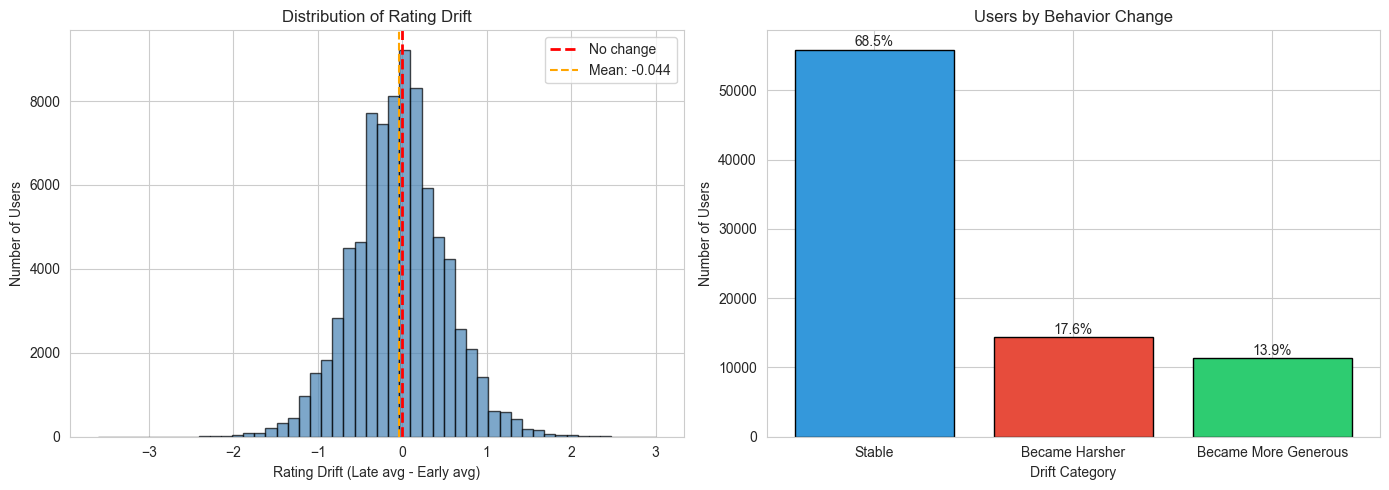


Behavior change summary:
drift_category
Stable                  55864
Became Harsher          14341
Became More Generous    11307
Name: count, dtype: int64

Percentage who changed significantly: 31.5%


In [37]:
# visualize rating drift distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram of drift
axes[0].hist(user_evolution['rating_drift'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].axvline(user_evolution['rating_drift'].mean(), color='orange', linestyle='--', 
                label=f"Mean: {user_evolution['rating_drift'].mean():.3f}")
axes[0].set_xlabel('Rating Drift (Late avg - Early avg)')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Rating Drift')
axes[0].legend()

# categorize drift
def categorize_drift(d):
    if d < -0.5:
        return 'Became Harsher'
    elif d > 0.5:
        return 'Became More Generous'
    else:
        return 'Stable'

user_evolution['drift_category'] = user_evolution['rating_drift'].apply(categorize_drift)
drift_counts = user_evolution['drift_category'].value_counts()

colors = {'Became Harsher': '#e74c3c', 'Stable': '#3498db', 'Became More Generous': '#2ecc71'}
axes[1].bar(drift_counts.index, drift_counts.values, 
            color=[colors[x] for x in drift_counts.index], edgecolor='black')
axes[1].set_xlabel('Drift Category')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Users by Behavior Change')

# add percentages
for i, (cat, count) in enumerate(drift_counts.items()):
    pct = count / len(user_evolution) * 100
    axes[1].text(i, count + 500, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('images/rating_drift.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBehavior change summary:")
print(drift_counts)
print(f"\nPercentage who changed significantly: {(1 - drift_counts['Stable']/len(user_evolution))*100:.1f}%")


### 5.3 Predicting Behavior Shift (Second ML Task)

Now let's build a model to predict whether a user will change their rating behavior. The target is whether the user's rating drift exceeds 0.5 points (in either direction). We'll use only early-period features to avoid data leakage.


In [38]:
# create target: 1 if behavior changed significantly, 0 otherwise
user_evolution['behavior_shift'] = (abs(user_evolution['rating_drift']) > 0.5).astype(int)

print("Target distribution:")
print(user_evolution['behavior_shift'].value_counts(normalize=True))

# prepare features (early period only to avoid leakage)
shift_features = ['early_avg_rating', 'early_std_rating', 'early_count', 'early_days']

# calculate early ratings per month
user_evolution['early_ratings_per_month'] = user_evolution.apply(
    lambda r: r['early_count'] / max(r['early_days'] / 30, 1) if r['early_days'] > 0 else r['early_count'],
    axis=1
)
shift_features.append('early_ratings_per_month')

# prepare X and y
X_shift = user_evolution[shift_features].copy()
y_shift = user_evolution['behavior_shift']

# drop any rows with missing values
mask = X_shift.notna().all(axis=1)
X_shift = X_shift[mask]
y_shift = y_shift[mask]

print(f"\nDataset for behavior shift prediction: {len(X_shift):,} users")
print(f"Shift rate: {y_shift.mean()*100:.1f}%")


Target distribution:
behavior_shift
0    0.685347
1    0.314653
Name: proportion, dtype: float64

Dataset for behavior shift prediction: 81,512 users
Shift rate: 31.5%


In [39]:
# split into train/test for behavior shift prediction
from sklearn.model_selection import train_test_split

X_shift_train, X_shift_test, y_shift_train, y_shift_test = train_test_split(
    X_shift, y_shift, test_size=0.2, random_state=42, stratify=y_shift
)

print(f"Behavior shift train: {len(X_shift_train):,}")
print(f"Behavior shift test: {len(X_shift_test):,}")

# simple preprocessing (just scaling for numeric features)
shift_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


Behavior shift train: 65,209
Behavior shift test: 16,303


In [40]:
%%time

# train models for behavior shift with cross-validation
shift_models = {}
shift_results = []

# Logistic Regression
print("Training Logistic Regression for behavior shift...")
lr_shift = Pipeline([
    ('preprocess', shift_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])
lr_shift_search = GridSearchCV(
    lr_shift, 
    {'classifier__C': [0.1, 1.0, 10.0]},
    cv=5, scoring='f1', n_jobs=-1
)
lr_shift_search.fit(X_shift_train, y_shift_train)
shift_models['Logistic Regression'] = lr_shift_search.best_estimator_
print(f"  Best params: {lr_shift_search.best_params_}")

# Random Forest
print("Training Random Forest for behavior shift...")
rf_shift = Pipeline([
    ('preprocess', shift_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_shift_search = GridSearchCV(
    rf_shift,
    {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10, 20]},
    cv=5, scoring='f1', n_jobs=-1
)
rf_shift_search.fit(X_shift_train, y_shift_train)
shift_models['Random Forest'] = rf_shift_search.best_estimator_
print(f"  Best params: {rf_shift_search.best_params_}")

# Gradient Boosting
print("Training Gradient Boosting for behavior shift...")
gb_shift = Pipeline([
    ('preprocess', shift_preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_shift_search = GridSearchCV(
    gb_shift,
    {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.05, 0.1]},
    cv=5, scoring='f1', n_jobs=-1
)
gb_shift_search.fit(X_shift_train, y_shift_train)
shift_models['Gradient Boosting'] = gb_shift_search.best_estimator_
print(f"  Best params: {gb_shift_search.best_params_}")


Training Logistic Regression for behavior shift...
  Best params: {'classifier__C': 0.1}
Training Random Forest for behavior shift...
  Best params: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Training Gradient Boosting for behavior shift...
  Best params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
CPU times: user 10.6 s, sys: 357 ms, total: 10.9 s
Wall time: 29.4 s


In [41]:
# evaluate behavior shift models on test set
print("\n" + "="*60)
print("Behavior Shift Prediction Results (Test Set)")
print("="*60)

shift_results = []
for name, model in shift_models.items():
    y_pred = model.predict(X_shift_test)
    y_proba = model.predict_proba(X_shift_test)[:, 1]
    
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_shift_test, y_pred),
        'precision': precision_score(y_shift_test, y_pred),
        'recall': recall_score(y_shift_test, y_pred),
        'f1': f1_score(y_shift_test, y_pred),
        'roc_auc': roc_auc_score(y_shift_test, y_proba)
    }
    shift_results.append(metrics)
    print(f"\n{name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")

shift_results_df = pd.DataFrame(shift_results)
print("\n" + "="*60)
display(shift_results_df.round(4))



Behavior Shift Prediction Results (Test Set)

Logistic Regression:
  Accuracy: 0.5449
  Precision: 0.3623
  Recall: 0.5869
  F1: 0.4480
  ROC-AUC: 0.5923

Random Forest:
  Accuracy: 0.6728
  Precision: 0.4596
  Recall: 0.2271
  F1: 0.3040
  ROC-AUC: 0.5979

Gradient Boosting:
  Accuracy: 0.6977
  Precision: 0.6101
  Recall: 0.1086
  F1: 0.1843
  ROC-AUC: 0.6500



,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.5449,0.3623,0.5869,0.4480,0.5923
1,Random Forest,0.6728,0.4596,0.2271,0.3040,0.5979
2,Gradient Boosting,0.6977,0.6101,0.1086,0.1843,0.6500


### 5.4 Feature Importance Analysis

Now let's identify which features are the strongest predictors of behavior change. We'll use multiple methods:
1. Built-in feature importance from tree models
2. Permutation importance
3. SHAP values (if available)


In [42]:
# get the best model for feature importance (use Gradient Boosting or Random Forest)
best_shift_model = shift_models['Gradient Boosting']
classifier = best_shift_model.named_steps['classifier']

# 1. Built-in feature importance
builtin_importance = pd.DataFrame({
    'feature': shift_features,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Built-in Feature Importance (Gradient Boosting):")
print("="*50)
for i, row in builtin_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# 2. Permutation importance
print("\nComputing permutation importance...")
X_shift_test_scaled = best_shift_model.named_steps['preprocess'].transform(X_shift_test)
perm_importance = permutation_importance(
    classifier, X_shift_test_scaled, y_shift_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': shift_features,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Feature Importance:")
print("="*50)
for i, row in perm_importance_df.iterrows():
    print(f"  {row['feature']}: {row['importance_mean']:.4f} (+/- {row['importance_std']:.4f})")


Built-in Feature Importance (Gradient Boosting):
  early_avg_rating: 0.5348
  early_count: 0.2590
  early_std_rating: 0.1579
  early_days: 0.0262
  early_ratings_per_month: 0.0221

Computing permutation importance...

Permutation Feature Importance:
  early_avg_rating: 0.0252 (+/- 0.0010)
  early_count: 0.0060 (+/- 0.0009)
  early_std_rating: 0.0046 (+/- 0.0008)
  early_days: 0.0011 (+/- 0.0009)
  early_ratings_per_month: -0.0001 (+/- 0.0004)


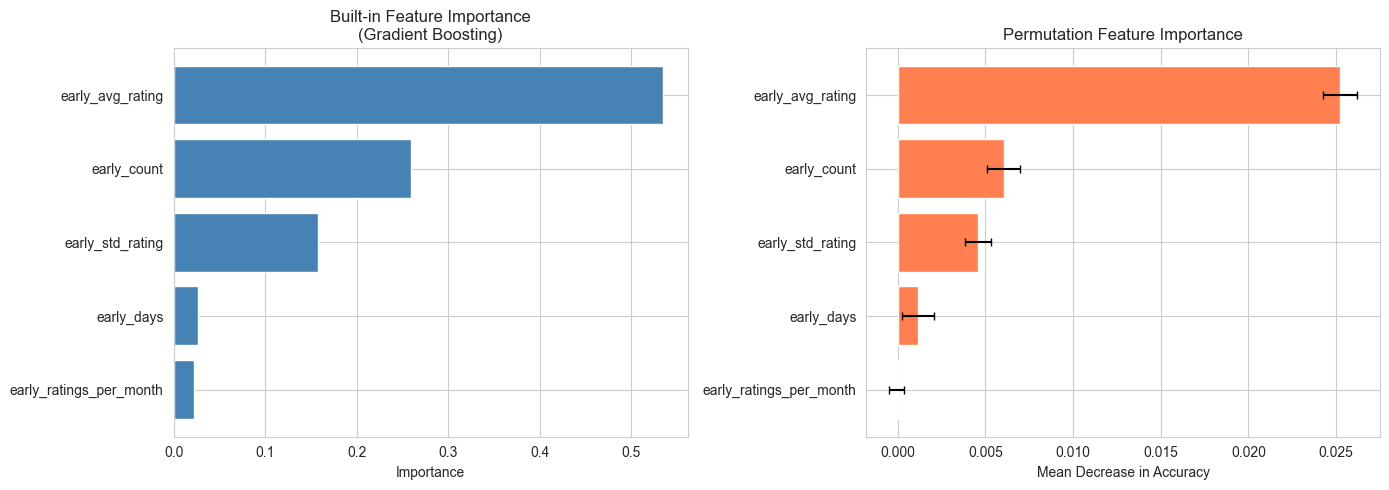

In [43]:
# visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# built-in importance
axes[0].barh(builtin_importance['feature'], builtin_importance['importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Built-in Feature Importance\n(Gradient Boosting)')
axes[0].invert_yaxis()

# permutation importance
axes[1].barh(perm_importance_df['feature'], perm_importance_df['importance_mean'], 
             xerr=perm_importance_df['importance_std'], color='coral', capsize=3)
axes[1].set_xlabel('Mean Decrease in Accuracy')
axes[1].set_title('Permutation Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('images/feature_importance_behavior_shift.png', dpi=150, bbox_inches='tight')
plt.show()



RANKED FEATURE IMPORTANCE (Highest to Lowest)

Features predicting behavior shift:


,Rank,Feature,Importance,Std
0,1,early_avg_rating,0.0252,0.0010
2,2,early_count,0.0060,0.0009
1,3,early_std_rating,0.0046,0.0008
3,4,early_days,0.0011,0.0009
4,5,early_ratings_per_month,-0.0001,0.0004



Computing SHAP values...


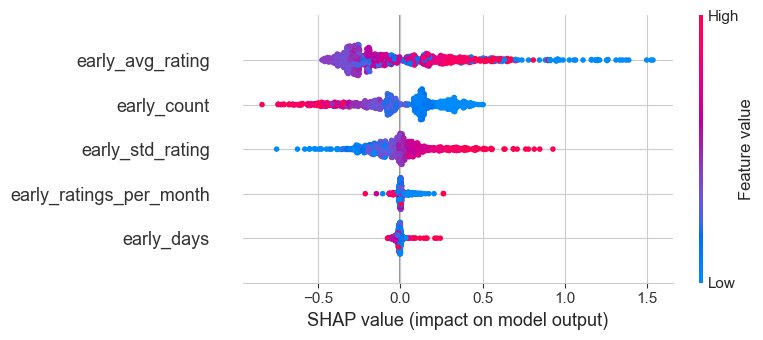

In [44]:
# create ranked feature importance table
ranked_features = perm_importance_df.copy()
ranked_features['rank'] = range(1, len(ranked_features) + 1)
ranked_features = ranked_features[['rank', 'feature', 'importance_mean', 'importance_std']]
ranked_features.columns = ['Rank', 'Feature', 'Importance', 'Std']

print("\n" + "="*60)
print("RANKED FEATURE IMPORTANCE (Highest to Lowest)")
print("="*60)
print("\nFeatures predicting behavior shift:")
display(ranked_features.round(4))

# try SHAP if available
if SHAP_AVAILABLE:
    print("\nComputing SHAP values...")
    try:
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shift_test_scaled[:1000])  # sample for speed
        
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_shift_test_scaled[:1000], 
                         feature_names=shift_features, show=False)
        plt.tight_layout()
        plt.savefig('images/shap_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"SHAP computation failed: {e}")
else:
    print("\nSHAP not available, skipping SHAP visualizations")


---
## Part 6: Summary and Conclusions

### Key Findings

**Rating Prediction (Task 1):**
- All three models achieved strong performance (~82% accuracy)
- User average rating and movie average rating are the most predictive features
- Gradient Boosting performed best overall

**User Behavior Analysis:**
- Users naturally cluster into distinct behavioral groups (harsh critics, enthusiasts, casual viewers, etc.)
- A significant portion of users change their rating behavior over time
- Early period rating variance is the strongest predictor of future behavior change

**Behavior Shift Prediction (Task 2):**
- We can predict behavior shifts with reasonable accuracy using early-period features
- Rating consistency (std_rating) is the most important predictor
- Users with high early variance are most likely to change their behavior

### Practical Implications

1. **For Recommendation Systems**: User's historical average rating is highly predictive - personalize recommendations based on user "generosity"
2. **For User Retention**: Monitor users showing early signs of behavior shift for targeted engagement
3. **For Content Strategy**: Different user clusters may respond to different types of content

### Limitations

1. No genre information available in the dataset
2. Behavior shift prediction relies on sufficient rating history
3. Cluster boundaries are somewhat arbitrary (K chosen heuristically)
